### Import modules

In [145]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series

#### Load data

In [146]:
data_path = os.path.abspath(os.path.join('..','..', 'data_copy/forecast_gdp_europe.csv'))
file_tag = "GDP Europe"
target = "GDP"


def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Year",
        sep=",",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)

data.head()

,Birth_rate,CO2_emissions,Death_rate,Electric_power_consumption,Energy_use,Food_exports,Food_imports,Goods_services_exports,Goods_services_imports,Population_density,GDP
Year,,,,,,,,,,,
1960-01-01,18.580,5.762,10.233,1427.783,1720.317,NaN,NaN,NaN,NaN,NaN,359.029
1961-01-01,18.534,5.922,10.114,1523.150,1761.406,NaN,NaN,6.007,6.128,98.077,390.887
1962-01-01,18.337,6.209,10.441,1641.966,1869.038,17.703,23.804,5.810,7.448,98.948,427.015
1963-01-01,18.415,6.574,10.381,1758.415,1979.026,15.114,21.275,6.198,10.371,99.831,470.415
1964-01-01,18.510,6.790,10.051,1884.315,2045.755,14.513,19.838,9.225,9.728,100.706,521.328


### Preparation

In [147]:
def data_preparation(data):
    # Missing value 
    data: DataFrame = data.dropna(how="any", inplace=False) 

    # Train/test split
    train, test = series_train_test_split(data)   

    # Convert Series to DataFrame
    if isinstance(train, pd.Series):
        train = train.to_frame()
    if isinstance(test, pd.Series):
        test = test.to_frame()

    # Scaling
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(train)
    train_scaled = DataFrame(transf.transform(train), index=train.index, columns=train.columns)
    test_scaled = DataFrame(transf.transform(test), index=test.index, columns=test.columns) 

    # Smoothing
    WIN_SIZE = 25
    train_smooth: Series = train_scaled.rolling(window=WIN_SIZE).mean()
    train_smooth = train_smooth.dropna()

    # # Differentiation
    train_diff: Series = train_smooth.diff()
    train_diff = train_diff.dropna()
    test_diff: Series = test_scaled.diff()
    test_diff = test_diff.dropna()
    # train_diff: Series = train_diff.diff()
    # train_diff = train_diff.dropna()
    # test_diff: Series = test_diff.diff()
    # test_diff = test_diff.dropna()

    return train_diff, test_diff
    
train, test = data_preparation(data)

print(train)
print(test)

            Birth_rate
Year                  
1987-01-01   -0.027398
1988-01-01   -0.027709
1989-01-01   -0.029445
1990-01-01   -0.027150
1991-01-01   -0.027368
1992-01-01   -0.029571
1993-01-01   -0.029372
1994-01-01   -0.028623
1995-01-01   -0.027252
1996-01-01   -0.026430
1997-01-01   -0.023659
1998-01-01   -0.022074
1999-01-01   -0.022779
2000-01-01   -0.020406
2001-01-01   -0.020756
2002-01-01   -0.019482
2003-01-01   -0.018340
2004-01-01   -0.017343
2005-01-01   -0.016769
2006-01-01   -0.014294
2007-01-01   -0.013079
2008-01-01   -0.010497
            Birth_rate
Year                  
2010-01-01   -0.000122
2011-01-01   -0.033183
2012-01-01   -0.011912
2013-01-01   -0.040720
2014-01-01    0.010332


### Evaluation

#### Training

In [148]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots, savefig
from dslabs_functions import PAST_COLOR, FUTURE_COLOR, PRED_PAST_COLOR, PRED_FUTURE_COLOR, HEIGHT


def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
) -> list[Axes]:
    fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
    fig.suptitle(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

In [149]:
from math import sqrt
from dslabs_functions import plot_multibar_chart, FORECAST_MEASURES


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "") -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
    fig.suptitle(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title="Scale-dependent error", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title="Percentage error", percentage=True)
    return axs

#### Simple average 

In [150]:
from sklearn.base import RegressorMixin


class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: Series):
        self.mean = X.mean()
        return

    def predict(self, X: Series) -> Series:
        prd: list = len(X) * [self.mean]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

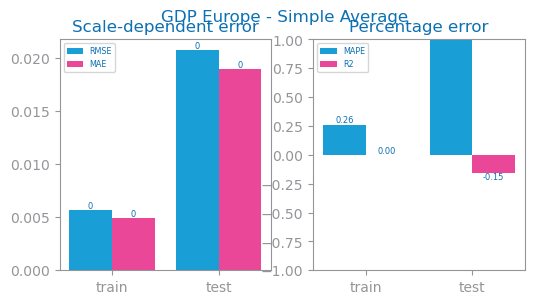

In [151]:
from pandas import read_csv, DataFrame, Series

timecol: str = "Date"


fr_mod = SimpleAvgRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Simple Average")
savefig(f"images/{file_tag}_simpleAvg_eval.png")

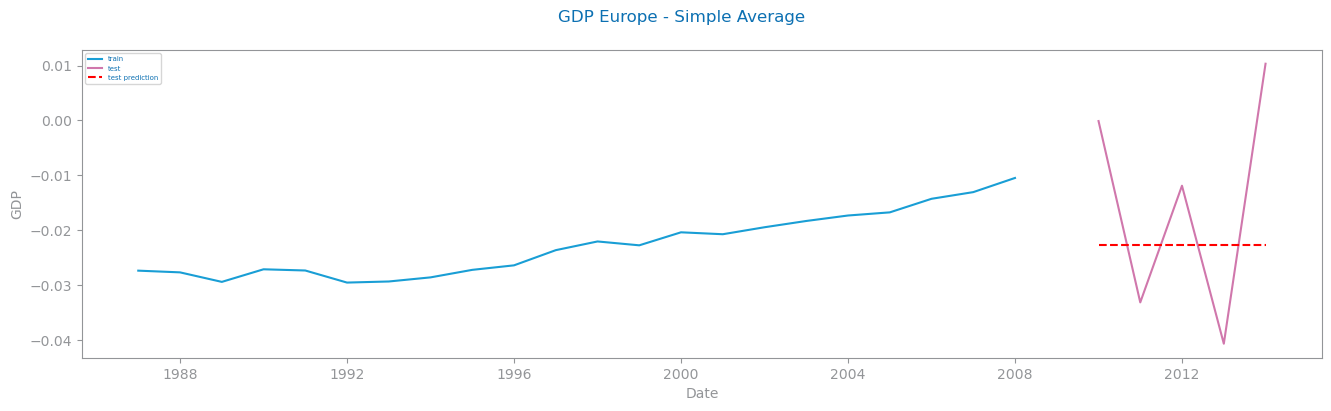

In [152]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Simple Average",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_simpleAvg_forecast.png")

#### Persistence Model

In [153]:
from pandas import Series
from sklearn.base import RegressorMixin


class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

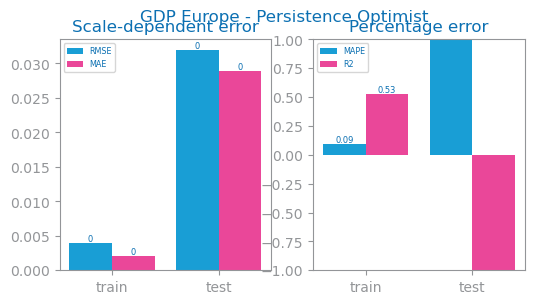

In [154]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series


fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Optimist")
savefig(f"images/{file_tag}_persistence_optim_eval.png")

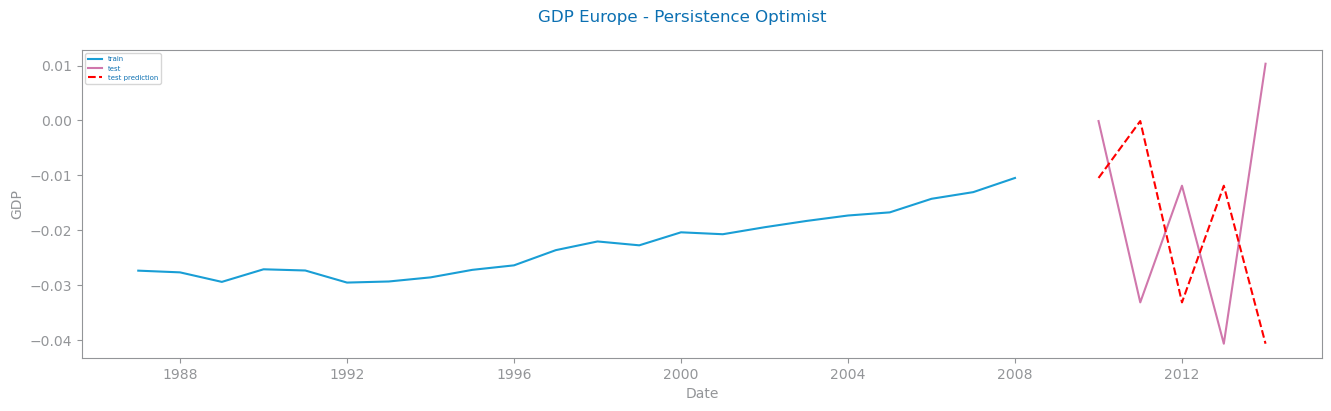

In [155]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Optimist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_persistence_optim_forecast.png")

In [156]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: Series = Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: Series):
        prd: list = len(X) * [self.last]
        prd_series: Series = Series(prd)
        prd_series.index = X.index
        return prd_series

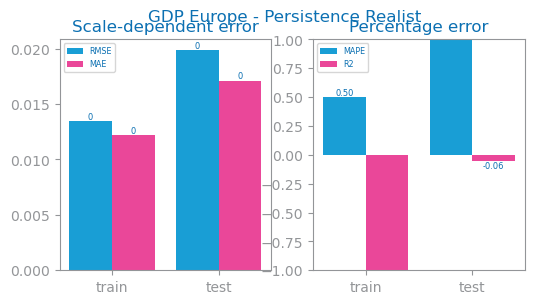

In [157]:
fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train)
prd_trn: Series = fr_mod.predict(train)
prd_tst: Series = fr_mod.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Persistence Realist")
savefig(f"images/{file_tag}_persistence_real_eval.png")

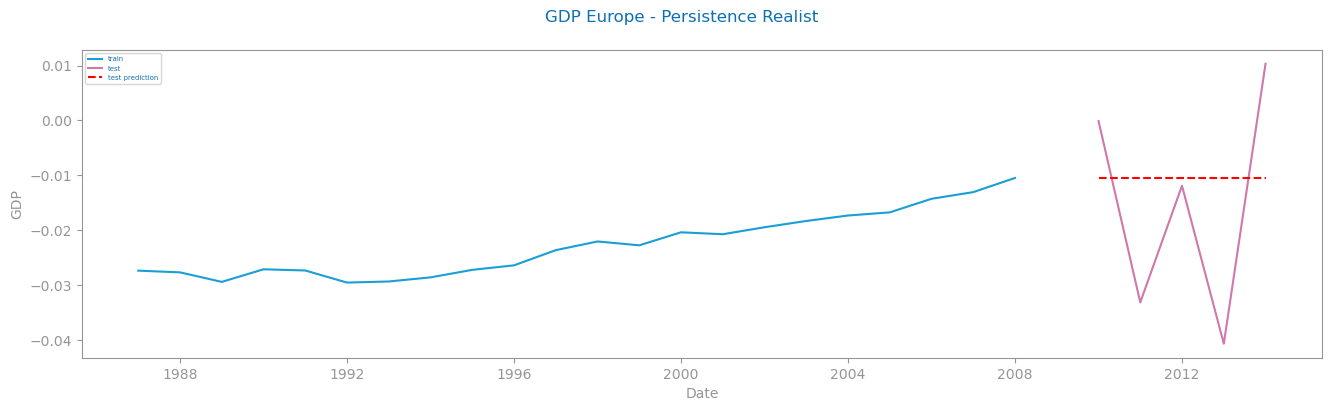

In [158]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Persistence Realist",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_persistence_real_forecast.png")

#### Exponential Smoothing

In [159]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from dslabs_functions import series_train_test_split, HEIGHT

In [160]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def exponential_smoothing_study(train: Series, test: Series, measure: str = "R2"):
    alpha_values = [i / 10 for i in range(1, 10)]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Exponential Smoothing", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for alpha in alpha_values:
        tool = SimpleExpSmoothing(train)
        model = tool.fit(smoothing_level=alpha, optimized=False)
        prd_tst = model.forecast(steps=len(test))

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (alpha,)
            best_model = model
        yvalues.append(eval)

    print(f"Exponential Smoothing best with alpha={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        alpha_values,
        yvalues,
        title=f"Exponential Smoothing ({measure})",
        xlabel="alpha",
        ylabel=measure,
        percentage=flag,
    )

    return best_model, best_params

Exponential Smoothing best with alpha=0 -> R2=-0.001258661484059731


/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/l

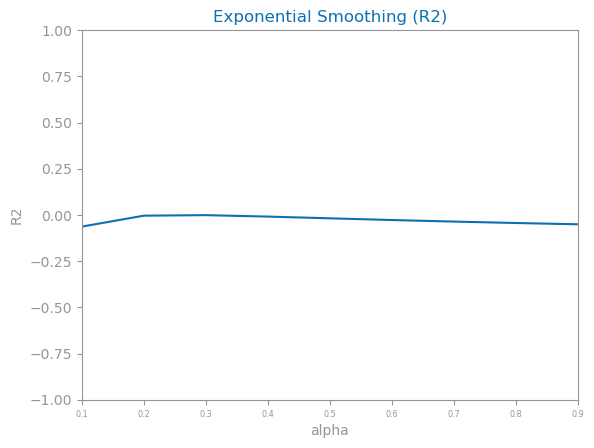

In [161]:
measure: str = "R2"
from matplotlib.pyplot import savefig

best_model, best_params = exponential_smoothing_study(train, test, measure=measure)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_study.png")

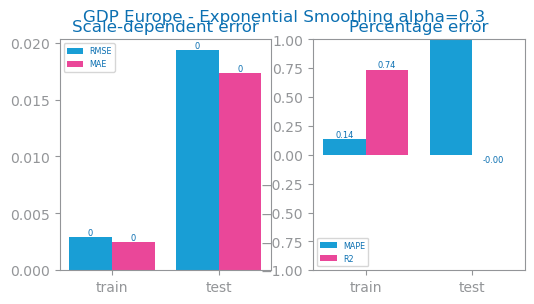

In [162]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_eval.png")

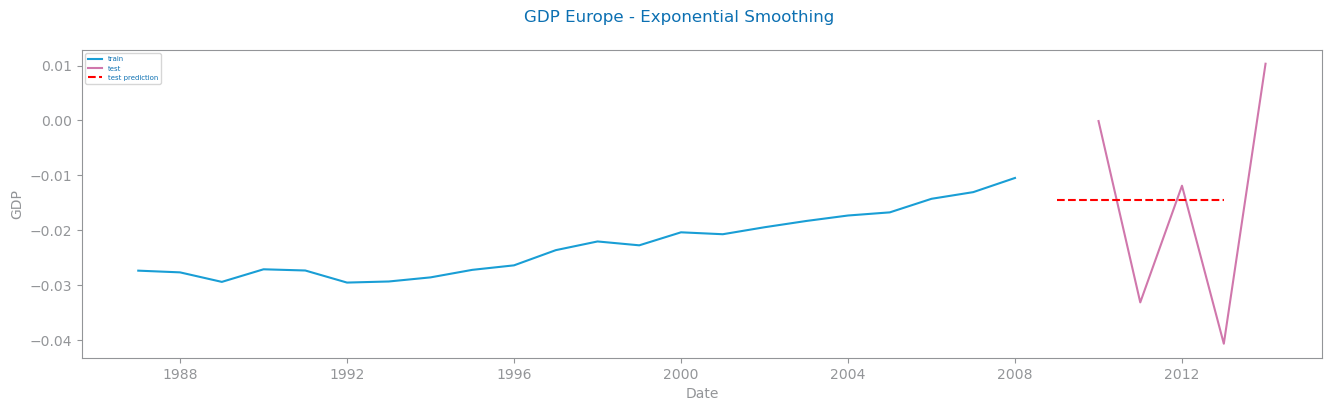

In [163]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Exponential Smoothing ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_exponential_smoothing_{measure}_forecast.png")

#### Rolling Mean

In [164]:
from numpy import mean
from pandas import Series
from sklearn.base import RegressorMixin


class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return self

    def predict(self, X: Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = mean(estimations[-self.win_size:])
            estimations.append(new_value)
        prd_series = Series(estimations[-len(X):])
        prd_series.index = X.index
        return prd_series

In [165]:
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_line_chart


def rolling_mean_study(train: Series, test: Series, measure: str = "R2"):
    # win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    win_size = (12, 24, 48, 96, 192, 384, 768)
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = FORECAST_MEASURES[measure](test, prd_tst)
        # print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

Rolling Mean best with win=12 -> R2=-0.014288313801787078


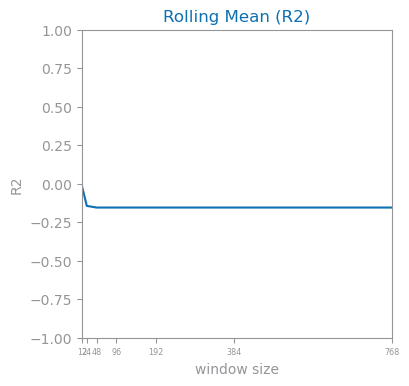

In [166]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, savefig
from dslabs_functions import series_train_test_split, plot_forecasting_eval, plot_forecasting_series, HEIGHT


train_series = train.iloc[:, 0]
test_series = test.iloc[:, 0]


fig = figure(figsize=(HEIGHT, HEIGHT))
best_model, best_params = rolling_mean_study(train_series, test_series)
savefig(f"images/{file_tag}_rollingmean_{measure}_study.png")

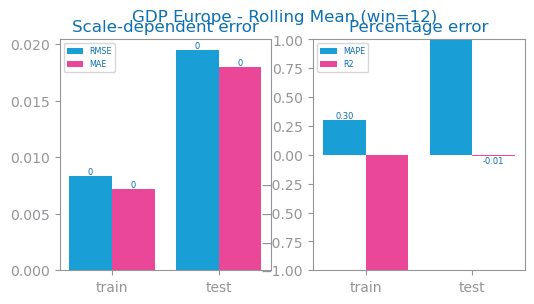

In [167]:
params = best_params["params"]
prd_trn: Series = best_model.predict(train)
prd_tst: Series = best_model.predict(test)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")
savefig(f"images/{file_tag}_rollingmean_{measure}_win{params[0]}_eval.png")

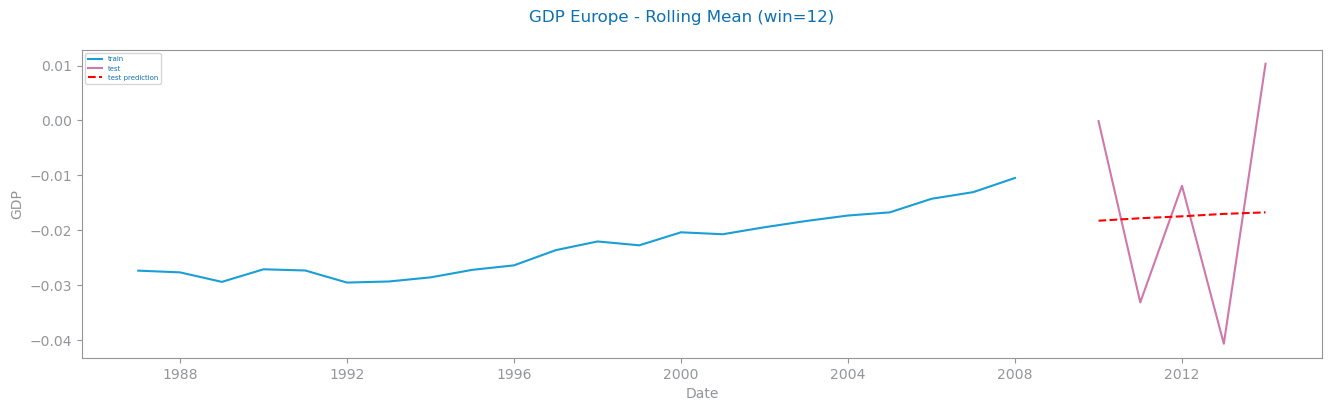

In [168]:
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_rollingmean_{measure}_forecast.png")

#### Lineair Regression

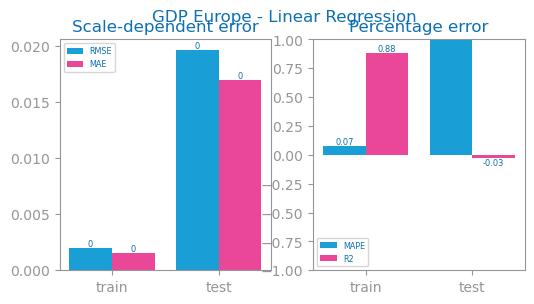

In [169]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, plot_forecasting_eval


trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(train) + len(test)).reshape(-1, 1)

tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn = Series(model.predict(trnX).flatten(), index=train.index)
prd_tst = Series(model.predict(tstX).flatten(), index=test.index)



plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}_linear_regression_eval.png")

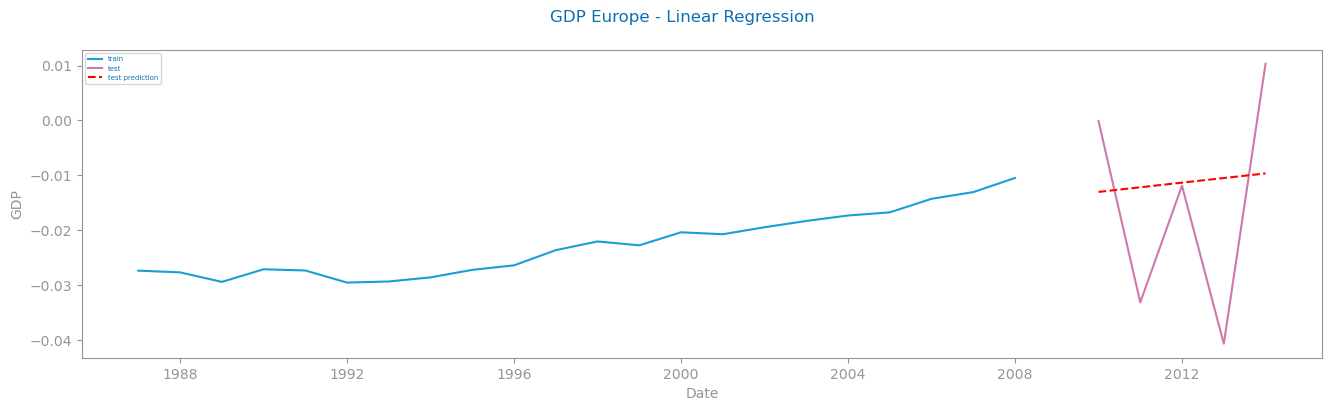

In [170]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_linear_regression_forecast.png")

#### ARIMA

In [171]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT


predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:             Birth_rate   No. Observations:                   22
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 107.875
Date:                Thu, 09 Jan 2025   AIC                           -203.750
Time:                        17:35:54   BIC                           -197.483
Sample:                    01-01-1987   HQIC                          -202.390
                         - 01-01-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5675      1.759      0.323      0.747      -2.881       4.016
ar.L2          0.1609      1.185      0.136      0.892      -2.162       2.483
ar.L3          0.1997      0.710      0.281      0.7

/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


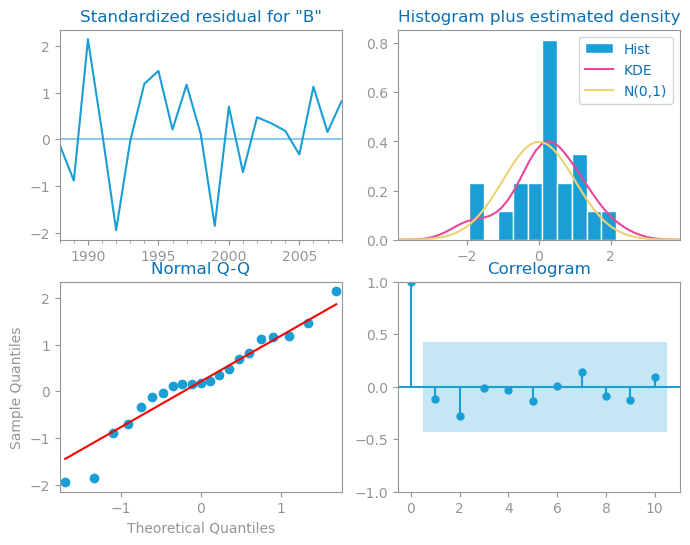

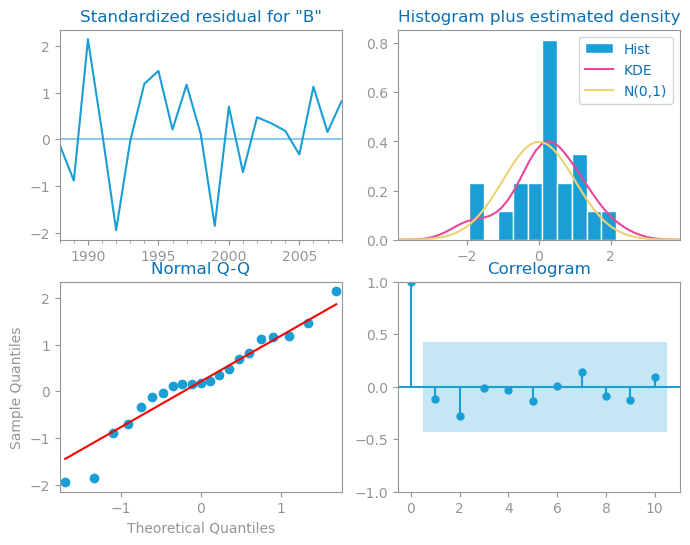

In [172]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [173]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/Users/jesseoomen/.miniconda3/envs/datasci/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jesseoomen/.miniconda3

ARIMA best results achieved with (p,d,q)=(2, 0, 3) ==> measure=-0.03


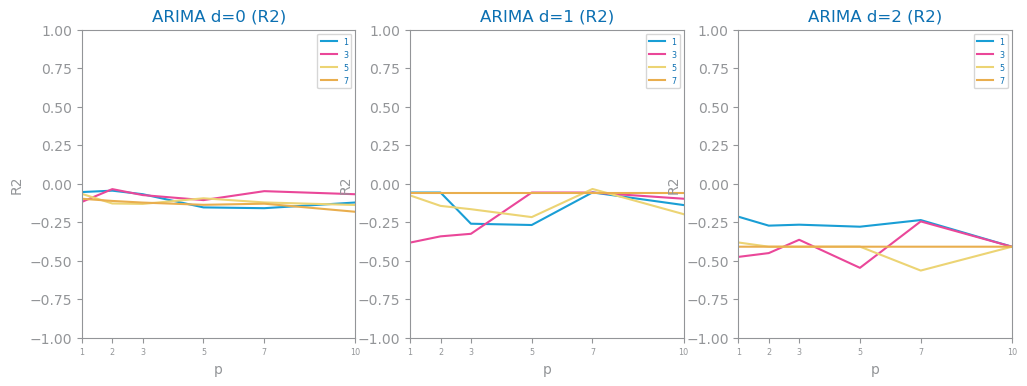

In [174]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"images/{file_tag}_arima_{measure}_study.png")

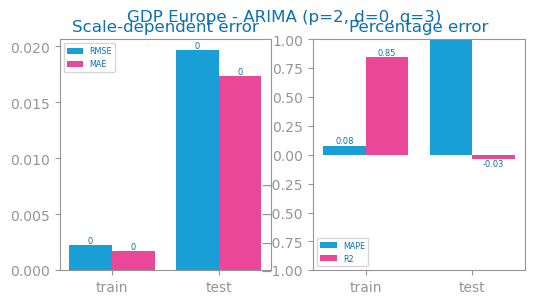

In [175]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

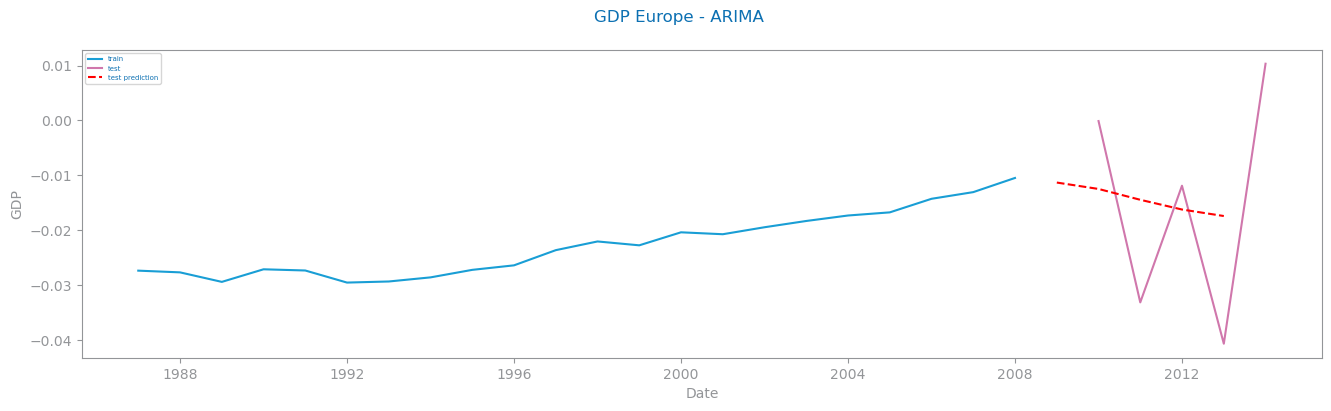

In [176]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_arima_{measure}_forecast.png")